# Importing Libraries

In [3]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt 
import sklearn.metrics as met
import scipy.stats as stats
import numpy as np
import string

import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim import models
from ast import literal_eval

from sklearn.model_selection import train_test_split
import phrase2vec as p2v
from model import ModelParams

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

### Code adopted from original Emoji2Vec paper for creating vector representations.
https://arxiv.org/abs/1609.08359

1. Create Word2Vec model  - p2v_no_emoji 
2. Create Emoji2Vec model - p2v_our_emoji

In [4]:
#loading word2Vec and emoji2Vec
w2v= api.load('word2vec-google-news-300')
e2v_ours_path = 'pre-trained/emoji2vec.bin'
e2v_ours = models.KeyedVectors.load_word2vec_format(e2v_ours_path, binary=True)


In [5]:
#The Emoji2Vec model
in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.0

params = ModelParams(in_dim=in_dim, out_dim=out_dim, pos_ex=pos_ex, max_epochs=max_epochs,
                    neg_ratio=neg_ratio, learning_rate=0.001, dropout=dropout, class_threshold=0.5)


In [12]:
'''
Phase2Vec: Wrapper for word2vec and emoji2vec models, so that we can query by entire phrase, rather than by
individual words.
'''
p2v_no_emoji = p2v.Phrase2Vec(out_dim, w2v, e2v=None)
p2v_our_emoji = p2v.Phrase2Vec(out_dim, w2v, e2v=e2v_ours)

### Loading Tweets

In [13]:
#Loading Processed Tweets
tweets=[]
file= pd.read_csv('tweets/sentiment_processed.csv')
depressed = file[file['sentiment']=='tensor(0)']
non_depressed = file[file['sentiment']=='tensor(1)']
#Setting negative class label to 0:
for i in range(non_depressed.shape[0]):
        non_depressed['label'].iloc[i]=0
tweets = pd.concat([depressed, non_depressed]).reset_index(drop=True)
tweets = tweets.dropna()

tweets
#Covertin tokens to string
sentences = []
for i in tweets.index:
    a = literal_eval(tweets['processed_text'].iloc[i])
    sentences.append(a)


preprocessed_sentences=[]
for i in tweets.index:
    preprocessed_sentences.append(' '.join(sentences[i]))
tweets['sen'] = preprocessed_sentences




In [14]:
#selecting only the columns we will actually use
df = tweets[['label', 'sen']]
print('Depressed',depressed.shape)
print('Non Depressed',non_depressed.shape)
tweets.shape, df.shape

Depressed (6553, 7)
Non Depressed (9013, 7)


((15566, 8), (15566, 2))

### Code adopted from original Emoji2Vec paper for creating vector representations.
https://arxiv.org/abs/1609.08359

In [15]:
import nltk.tokenize as tk
def prepare_tweet_vector_averages(tweets, p2v):
    """Take the vector sum of all tokens in each tweet
    Args:
        tweets: All tweets
        p2v: Phrase2Vec model
    Returns:
        Average vectors for each tweet
        Truth
    """
    tokenizer = tk.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

    avg_vecs = list()
    

    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        avg_vecs.append(np.sum([p2v[x] for x in tokens], axis=0) / len(tokens))

    return avg_vecs

In [40]:
#Creating test splits
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(np.array(df['sen']), np.array(df['label']), test_size=0.2)
train_w2v = prepare_tweet_vector_averages(X_train, p2v_no_emoji)
train_e2v = prepare_tweet_vector_averages(X_train, p2v_our_emoji)
test_w2v  = prepare_tweet_vector_averages(X_test, p2v_no_emoji)
test_e2v = prepare_tweet_vector_averages(X_test, p2v_our_emoji)

### Behavior of the two models corresponding to an emoji

In [171]:
vec = p2v_our_emoji['😄'][0:10]

array([ 0.05808197, -0.01469222,  0.06606557,  0.06281745, -0.07089687,
       -0.01058779,  0.02780172, -0.07202497,  0.06981696,  0.07128274],
      dtype=float32)

In [172]:
vec = p2v_no_emoji['😄'][0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Model Evaluations

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras import layers

### Model 

#### Hyperparameters Tuned

params_grid_lr = [{'penalty': ['l1', 'l2', 'elasticnet']}]

params_grid_svm = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}]

param_grid_random_forest = { 
        'n_estimators': [200, 100,300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [5,10],
        'criterion' :['gini', 'entropy']                             }

param_grid_adaboost = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__max_depth" : [5,10],
                  "n_estimators": [5, 10,20]
                 } 

param_grid_decision_tree = {"criterion" : ["gini", "entropy"],
                  "splitter" :   ["best", "random"],
                  "max_depth" : [5,10,15,20]
                 }



KNN Results:

Neural Network results:

Performance evaluation Emoji2Vec
train score 0.8477352857589722
test score 0.8346178531646729
F1 score  0.7996888370283938


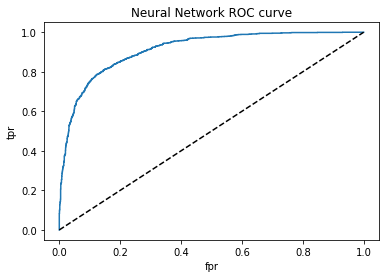


Performance evaluation Word2Vec
train score 0.85054612159729
test score 0.8352600932121277
F1 score  0.7950459448661605


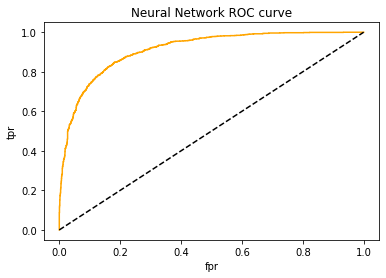

In [132]:
#Best parameters identified using GridSearchCV

e2v=[]
w2v=[]



def logistic_regression(x_train,y_train,x_test,y_test,p):
    
    classifier = LogisticRegression(penalty='l2')
    clf = classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    scLogistic = accuracy_score(y_test,y_pred)
    print("test score  " ,scLogistic)
    f1LR =  f1_score(y_test,y_pred)
    print("F1 score " ,f1LR)
    roc(x_test,y_test,clf,'Logistic Regression',p)
    return scLogistic

def svm(x_train,y_train,x_test,y_test,p):
    
    classifier = SVC(kernel='rbf', gamma='scale',probability=True)
    clf = classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    scSVM = accuracy_score(y_test,y_pred)
    print("test score  " ,scSVM)
    f1SVM =  f1_score(y_test,y_pred)
    print("F1 score " ,f1SVM)
    roc(x_test,y_test,clf,'SVM',p)
    return scSVM



def neural_network(x_train,y_train,x_test,y_test,p):
    input_shape = (300,)
    batch_size=64
    epochs = 20
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    classifier = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.8),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.8),
                layers.Dense(2, activation='sigmoid', name='output')
            ]
        )
    train_labels_onehot = keras.utils.to_categorical(y_train, 2)
    test_labels_onehot = keras.utils.to_categorical(y_test, 2)
    classifier.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = classifier.fit(x_train,train_labels_onehot, batch_size=batch_size, epochs=epochs, shuffle=True,validation_split=0.15, verbose=0)
    score_test = classifier.evaluate(x_test,test_labels_onehot, verbose=0)
    score_train = classifier.evaluate(x_train,train_labels_onehot, verbose=0)
    y_pred=np.argmax(classifier.predict(x_test), axis=1)
    print("train score", score_train[1])
    print("test score", score_test[1])
    f1nn =  f1_score(y_test,y_pred)
    print("F1 score " ,f1nn)
    roc(x_test,y_test,classifier,'Neural Network',p)
    return score_test[1]
    
def random_forest(x_train,y_train,x_test,y_test,p):
    classifier=RandomForestClassifier(criterion ='entropy', max_depth = 10, max_features = 'auto', n_estimators = 200)
    clf=classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    scRF = accuracy_score(y_test,y_pred)
    print("test score " ,scRF)
    f1RF =  f1_score(y_test,y_pred)
    print("F1 score " ,scRF)
    roc(x_test,y_test,clf,'Random Forest',p)
    return scRF

def ada_boost(x_train,y_train,x_test,y_test,p):
    classifier_tree = DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth=20)
    classifier = AdaBoostClassifier(base_estimator = classifier_tree,n_estimators = 20)
    clf=classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    scADA = accuracy_score(y_test,y_pred)
    print("test score " ,scADA)
    f1ADA =  f1_score(y_test,y_pred)
    print("F1 score " ,scADA)
    roc(x_test,y_test, clf,'Adaboost',p)
    return scADA 
    
    
def decision_trees(x_train,y_train,x_test,y_test,p):
    classifier =DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth=10)
    clf=classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    DT = accuracy_score(y_test,y_pred)
    print("test score " ,DT)
    f1DT =  f1_score(y_test,y_pred)
    print("F1 score " ,f1DT)
    roc(x_test,y_test,clf,'Decision Tree',p)
    return DT

def naive(x_train,y_train,x_test,y_test,p):
   
    classifier = GaussianNB()
    clf=classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    GNB = accuracy_score(y_test,y_pred)
    print("test score " ,GNB)
    f1GNB =  f1_score(y_test,y_pred)
    print("F1 score " ,f1GNB)
    roc(x_test,y_test,clf,'Gaussian NB',p)
    return GNB 

def knn_model(x_train,y_train,x_test,y_test,k,p):
    print('KNeighbors Algorithm model for k:{}'.format(k))
    classifier = KNeighborsClassifier(n_neighbors =k)
    clf=classifier.fit(x_train,y_train)
    print("train score: ",clf.score(x_train,y_train))
    y_pred = clf.predict(x_test)
    scKNN = accuracy_score(y_test,y_pred)
    print("test score  " ,scKNN)
    f1KNN =  f1_score(y_test,y_pred)
    print("F1 score " ,f1KNN)
    roc(x_test,y_test,clf,'KNN',p)
    return scKNN

def roc(x_test,y_test,model,param,p):
    if param=='Neural Network':
        y_score = model.predict(x_test)[:,1]
    else:
        y_score = model.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    if p=='w2v':
        plt.plot(fpr,tpr,color='orange')
    else:
        plt.plot(fpr,tpr,color='C0')
  
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(param +' ROC curve')
    plt.show()
    
def main():
    
    knn_e2v=[]
    knn_w2v=[]
    naive_e2v=[]
    naive_w2v=[]
    dt_e2v=[]
    dt_w2v=[]
    ada_e2v=[]
    ada_w2v=[]
    rf_e2v=[]
    rf_w2v=[]
    svm_e2v=[]
    svm_w2v=[]
    lr_e2v=[]
    lr_w2v=[]
    nn_e2v=[]
    nn_w2v=[]
    
    
    for i in range(0,1):
        print('\nKNN Results:')
        
        print('\nPerformance evaluation Emoji2Vec')
        acc=knn_model(train_e2v,y_train,test_e2v,y_test,10,'e2v')
        knn_e2v.append(acc)


        print('\nPerformance evaluation Word2Vec')
        acc=knn_model(train_w2v,y_train,test_w2v,y_test,10,'w2v')
        knn_w2v.append(acc)
      


        print('\nGaussian NB results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=naive(train_e2v,y_train,test_e2v,y_test,'e2v')
        naive_e2v.append(acc)

        print('\nPerformance evaluation Word2Vec')
        acc=naive(train_w2v,y_train,test_w2v,y_test,'w2v')
        naive_w2v.append(acc)
        

        print('\nDecision tree results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=decision_trees(train_e2v,y_train,test_e2v,y_test,'e2v')
        dt_e2v.append(acc)


        print('\nPerformance evaluation Word2Vec')
        acc=decision_trees(train_w2v,y_train,test_w2v,y_test,'w2v')
        dt_w2v.append(acc)
        

        print('\nAdaboost results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=ada_boost(train_e2v,y_train,test_e2v,y_test,'e2v')
        ada_e2v.append(acc)


        print('\nPerformance evaluation Word2Vec')
        acc=ada_boost(train_w2v,y_train,test_w2v,y_test,'w2v')
        ada_w2v.append(acc)
        

        print('\nRandom forest results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=random_forest(train_e2v,y_train,test_e2v,y_test,'e2v')
        rf_e2v.append(acc)


        print('\nPerformance evaluation Word2Vec')
        acc=random_forest(train_w2v,y_train,test_w2v,y_test,'w2v')
        rf_w2v.append(acc)
     

        print('\nSVM results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=svm(train_e2v,y_train,test_e2v,y_test,'e2v')
        svm_e2v.append(acc)


        print('\nPerformance evaluation Word2Vec')
        acc=svm(train_w2v,y_train,test_w2v,y_test,'w2v')
        svm_w2v.append(acc)
        

        print('\nLogistic regression results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=logistic_regression(train_e2v,y_train,test_e2v,y_test,'e2v')
        lr_e2v.append(acc)

        print('\nPerformance evaluation Word2Vec')
        acc=logistic_regression(train_w2v,y_train,test_w2v,y_test,'w2v')
        lr_w2v.append(acc)
        
        print('\nNeural Network results:')
        print('\nPerformance evaluation Emoji2Vec')
        acc=neural_network(train_e2v,y_train,test_e2v,y_test,'e2v')
        nn_e2v.append(acc)
       
        print('\nPerformance evaluation Word2Vec')
        acc=neural_network(train_w2v,y_train,test_w2v,y_test,'w2v')
        nn_w2v.append(acc)
       
    
    
    #Averaging accuracy over 4 iterations
    e2v.append(round((sum(knn_e2v)/4)*100,2))
    w2v.append(round((sum(knn_w2v)/4)*100,2))
    e2v.append(round((sum(naive_e2v)/4)*100,2))
    w2v.append(round((sum(naive_w2v)/4)*100,2))
    e2v.append(round((sum(dt_e2v)/4)*100,2))
    w2v.append(round((sum(dt_w2v)/4)*100,2))
    e2v.append(round((sum(ada_e2v)/4)*100,2))
    w2v.append(round((sum(ada_w2v)/4)*100,2))
    e2v.append(round((sum(rf_e2v)/4)*100,2))
    w2v.append(round((sum(rf_w2v)/4)*100,2))
    e2v.append(round((sum(svm_e2v)/4)*100,2))
    w2v.append(round((sum(svm_w2v)/4)*100,2))
    e2v.append(round((sum(lr_e2v)/4)*100,2))
    w2v.append(round((sum(lr_w2v)/4)*100,2))
    e2v.append(round((sum(nn_e2v)/4)*100,2))
    w2v.append(round((sum(nn_w2v)/4)*100,2))
    
    

if __name__ == '__main__':
    main()





### Data Distribution Analysis

depressed_tweet with emojis 951
non_depressed_tweet with emojis 1372
total tweets 15566


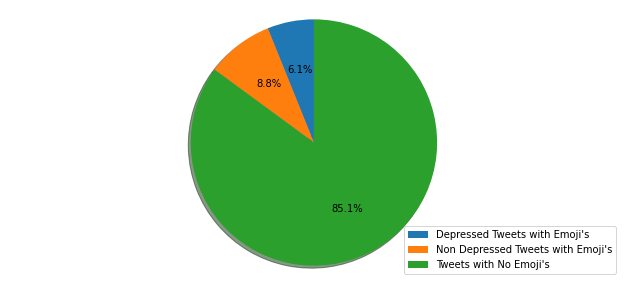

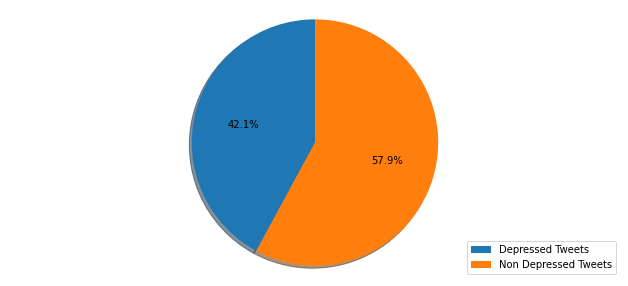

In [126]:
def get_emojis_in_tweet(tweet, emojis_ours, tokenizer):
    """Get a list of all the emojis in a tweet based on the sets provided
    Args:
        tweet: Tweet
        emojis_ours: Emoji vectors trained on our model
        emojis_theirs: Emoji vectors trained on an external model
        emojis_popular: List of popular emojis
        tokenizer: NLTK tokenizer
    Returns:
        Emojis in a tweet
    """
    tokens = tokenizer.tokenize(tweet)
    ems = set()
    for token in tokens:
        if token in emojis_ours:
            ems.add(token)
    return ems

def get_tweets_with_emoji(tweets, emojis_ours):
    """Get all tweets with emoji in the sets
    Args:
        tweets: List of Tweets
        emojis_ours: Emoji vectors trained on our model
        emojis_theirs: Emoji vectors trained on an external model
        emojis_popular: List of popular emojis
    Returns:
        All tweets containing emoji
    """
    tokenizer = tk.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    ems = list()
    for i,tweet in enumerate(tweets):
        if get_emojis_in_tweet(tweet, emojis_ours, tokenizer):
            ems.append([tweet,i])
    return ems

depressed_tweet=get_tweets_with_emoji(tweets[tweets['label']==1]['sen'],e2v_ours)
print('depressed_tweet with emojis',len(depressed_tweet))

non_depressed_tweet=get_tweets_with_emoji(tweets[tweets['label']==0]['sen'],e2v_ours)
print('non_depressed_tweet with emojis',len(non_depressed_tweet))

print('total tweets',tweets.shape[0])

#Plot data distribution - emoji's
labels = ["Depressed Tweets with Emoji's", "Non Depressed Tweets with Emoji's","Tweets with No Emoji's"]
x=[len(depressed_tweet) , len(non_depressed_tweet), tweets.shape[0]-(len(depressed_tweet)+len(non_depressed_tweet))]
fig1, ax1 = plt.subplots(figsize=(11,5))
ax1.pie(x, autopct='%1.1f%%',
        shadow=True, startangle=90,)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,loc="lower right")


labels2 = ["Depressed Tweets", "Non Depressed Tweets"]
y=[len(tweets[tweets['label']==1]) , len(tweets[tweets['label']==0])]
fig1, ax1 = plt.subplots(figsize=(11,5))
ax1.pie(y, autopct='%1.1f%%',
        shadow=True, startangle=90,)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels2,loc="lower right")



### Comparison Plot

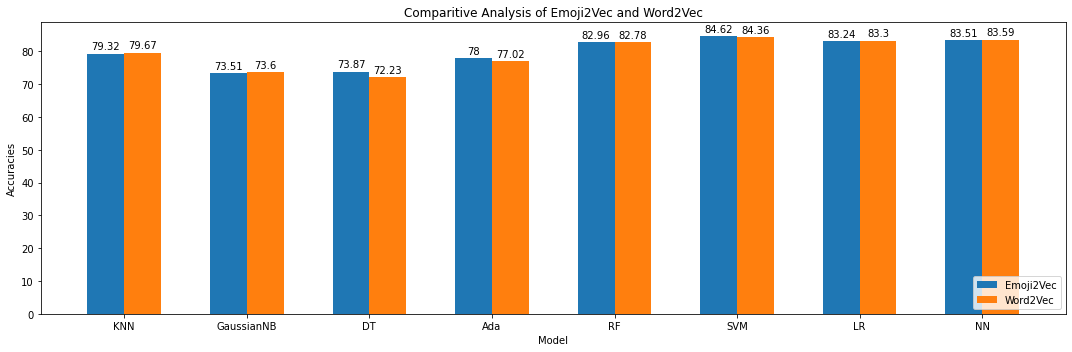

In [74]:

#Plotting
labels=['KNN','GaussianNB','DT','Ada','RF','SVM','LR','NN']
model_e2v=e2v
model_w2v=w2v

x = np.arange(len(labels))
width = 0.30

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, model_e2v, width, label='Emoji2Vec')
rects2 = ax.bar(x + width/2, model_w2v, width, label='Word2Vec')

ax.set_ylabel('Accuracies')
ax.set_xlabel('Model')
ax.set_title('Comparitive Analysis of Emoji2Vec and Word2Vec')
ax.set_xticks(x, labels)
ax.legend(loc='lower right')

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)

fig.tight_layout()

plt.show()